In [1]:
# In this notebook, I remove outliers, interpolate abnormal absorbance points and remove noisy wavelengths.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyexcel.cookbook import merge_all_to_a_book
from matplotlib.cbook import boxplot_stats
import glob

plt.rcParams["figure.figsize"]=20,10
plt.rcParams.update({'font.size': 28})
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
def plot(data):
    fig, ax = plt.subplots()
    if data.ndim == 1:
        a = plt.plot(data)
    else:
        a = plt.plot(data.columns, data.T)
    
#     plt.xticks([])
    plt.title('Absorbance x Wavelength')
    plt.xlabel('Wavelength')
    plt.ylabel('Absorbance')

In [306]:
df = pd.read_csv('../data/final/sergio.csv', index_col=0)

# selecting relevant wavelengths

In [307]:
wvls = list(df.loc[:, '711.2805':'1038578'].columns.values)
info = list(df.columns[:14].values)

In [308]:
all_cols = info + wvls

In [309]:
df = df.loc[:, all_cols]

# treating outliers

In [310]:
outliers = df[wvls][df[wvls].values > 5]
outliers = outliers.append(df[wvls][df[wvls].values < -5])

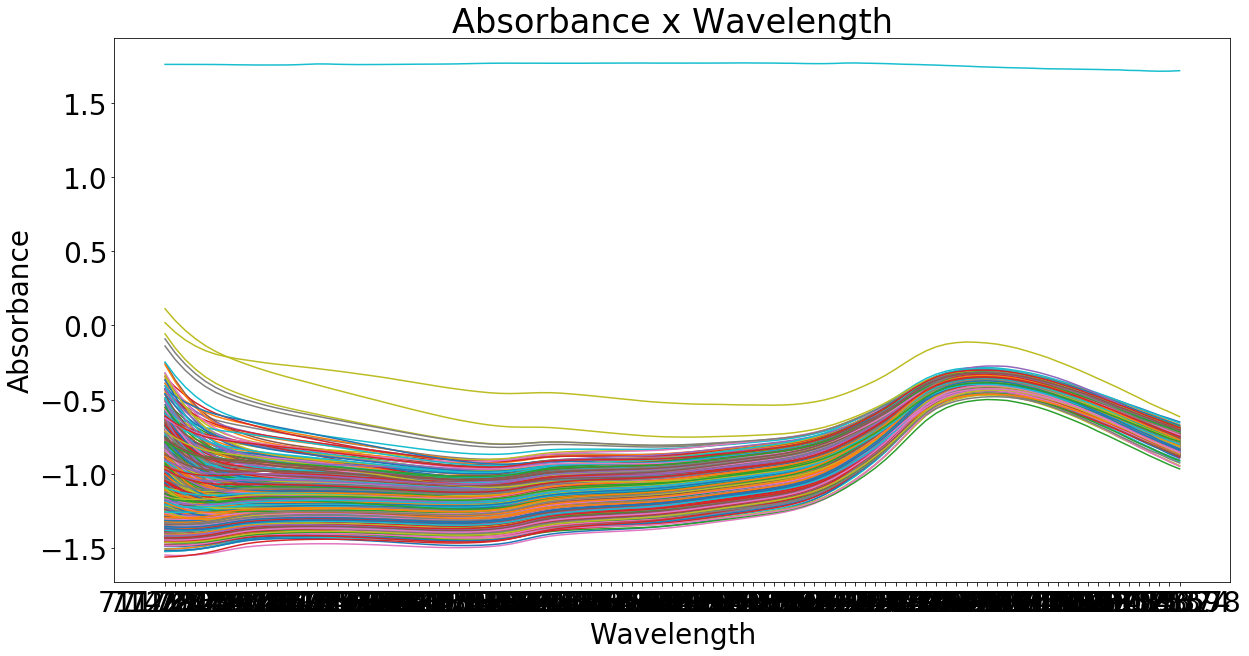

In [311]:
plot(df.drop(outliers.index)[wvls])

In [317]:
max_abs = max(df[wvls].mean(axis=1))

In [331]:
df['stupid'] = df[wvls].mean(axis=1)

In [333]:
df.loc[df['stupid'] == max(df['stupid'])]

,TREATMENT,BLOCK,SHELF-LIFE,FRESH MASS,L,C,H,FIRMNESS,LP,CP,...,1012901,1016116,1019.33,1022543,1025753,1028962,1032169,1035374,1038578,stupid
160,T3,B1,2,502.87,NaN,NaN,NaN,2.0,71.69,71.2,...,1.722959,1.721128,1.720347,1.71701,1.715911,1.712887,1.711341,1.711833,1.714964,1.753508


In [335]:
df.drop([160], inplace=True)

In [336]:
df.drop(outliers.index, inplace=True)
# qua_data.drop(outliers.index, inplace=True)

In [337]:
df.to_csv('../data/final/sergio_treated.csv')

# the rest was not necessary after using sérgio's data \\/

In [204]:
# I'm not using this anymore, but it was so beautiful
outliers_per_sample = outliers.apply(lambda x: boxplot_stats(x)[0]['fliers'], axis=1)

# for some reason there are duplicated samples
unique_outliers = outliers_per_sample[~outliers_per_sample.index.duplicated(keep='first')]

In [20]:
# make outliers equal to NaN
nan_abs_data = abs_data.iloc[unique_outliers.index.values]\
.apply(lambda series: series
       .map(lambda value: np.NaN if value in unique_outliers[series.name] else value), axis=1)

In [21]:
abs_data.iloc[nan_abs_data.index] = nan_abs_data

# interpolating linearly

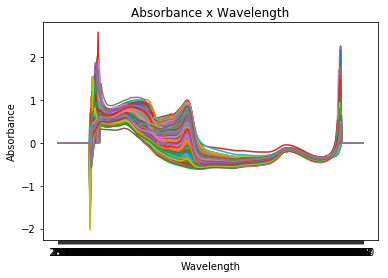

In [29]:
plot(abs_data)

In [25]:
abs_data.interpolate(limit=10, inplace=True)

In [26]:
# there is still a weird sample outlier (sample 234)

In [27]:
abs_data.iloc[234][['498','510','534','555','576','588','606','615','636','693','696','801','825',\
                    '834','837','948','963','1026',
                    '1056','1062','1077']] = np.nan

In [28]:
abs_data.interpolate(limit=10, inplace=True)

In [ ]:
# new df

In [30]:
treated = pd.concat([qua_data,abs_data], sort=False, axis=1)

In [ ]:
# raw data with nan values

In [31]:
treated.to_csv('../data/final/firmness_all_bands.csv')

In [84]:
treated.to_csv('../data/final/nan_data.csv')

# removing samples that contains nan values

In [231]:
atts = qua_data.columns[3:].values
dic = {'color': ['L', 'C', 'H'], 'fresh mass': 'FRESH MASS', 'firmness': 'FIRMNESS', \
       'color_p': ['LP', 'CP', 'HP'], 'sst': 'SST', 'acidity': 'TOTAL ACIDITY', 'dry mass': 'DRY MASS'}

In [233]:
for att in dic.keys():
    if type(dic[att]) == list:
        var = meta + dic[att] + wvls
    else:
        var = meta + [dic[att]] + wvls
        
    treated[var].dropna().reset_index(drop=True).to_csv('../data/final/abs_%s.csv' % att)

In [ ]:
# changing dot to comma, so I can send it to the others

In [238]:
def func (value):
    value = str(value).replace('.', ',')
    if value == 'nan':
        value = np.nan
    return value

In [239]:
formatted = treated.applymap(func)

In [240]:
for att in dic.keys():
    if type(dic[att]) == list:
        var = meta + dic[att] + wvls
    else:
        var = meta + [dic[att]] + wvls
        
    formatted[var].dropna().reset_index(drop=True).to_csv('../data/final/xlsx/abs_%s.csv' % att)

In [191]:
meta = list(qua_data.columns[:3].values)